In [501]:
# data wrangling
import pandas as pd
import numpy as np

# turn off scientific notation
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from pandas.plotting import register_matplotlib_converters

# modeling
from fbprophet import Prophet # Facebook library for time series analysis

# Spend projections for 2017

In [448]:
# import data
raw = pd.read_csv("2017_stackadapt_dataset_ts_2016.csv")
raw2 = pd.read_csv("2017_stackadapt_dataset.csv")

# lower case
raw.columns = [column.lower() for column in raw]
raw2.columns = [column.lower().replace(' ','_') for column in raw2]

In [101]:
raw.head()

,date,impressions,clicks,ctr,cpm,cpc,cpe,spend
0,16-01-01,219025,3972,0.01813,2.100,0.116,5.000,459.928608
1,16-01-02,186867,3435,0.01838,2.074,0.112,5.618,387.689816
2,16-01-03,198764,2914,0.01466,1.996,0.136,5.360,396.599524
3,16-01-04,285942,4498,0.01573,1.980,0.126,6.294,566.410954
4,16-01-05,323668,5573,0.01722,1.946,0.112,2.332,629.694128


In [102]:
raw.shape

(366, 8)

In [103]:
raw.isnull().sum() # no nulls

date           0
impressions    0
clicks         0
ctr            0
cpm            0
cpc            0
cpe            0
spend          0
dtype: int64

In [108]:
raw.describe()

,impressions,clicks,ctr,cpm,cpc,cpe,spend
count,3.660000e+02,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1.727218e+06,17227.519126,0.010096,2.414596,0.252825,3.045699,4158.310104
std,7.802517e+05,9795.982779,0.002771,0.519922,0.078055,1.492051,1920.306549
min,1.868670e+05,2914.000000,0.000000,1.436000,0.096000,0.858000,387.689816
25%,1.217682e+06,11531.250000,0.008177,2.063500,0.200000,2.072000,2959.246981
50%,1.621091e+06,15096.000000,0.009675,2.372000,0.240000,2.750000,3904.865699
75%,2.077554e+06,20439.500000,0.011187,2.678000,0.306000,3.538500,5085.737469
max,5.761379e+06,71459.000000,0.024650,4.582000,0.504000,15.552000,12326.860930


In [107]:
cpm_mean = raw.describe()['cpm']['mean']
cpc_mean = raw.describe()['cpc']['mean']
cpe_mean = raw.describe()['cpe']['mean']

* cpcv is missing

In [106]:
# date time
raw['date'] = pd.to_datetime(raw.date.apply(lambda x: x.replace('-','/')),format='%y/%m/%d')
raw.dtypes

date           datetime64[ns]
impressions             int64
clicks                  int64
ctr                   float64
cpm                   float64
cpc                   float64
cpe                   float64
spend                 float64
dtype: object

In [109]:
df = raw[['date','spend']]

In [110]:
df.head()

,date,spend
0,2016-01-01,459.928608
1,2016-01-02,387.689816
2,2016-01-03,396.599524
3,2016-01-04,566.410954
4,2016-01-05,629.694128


In [111]:
df.columns = ['ds', 'y']

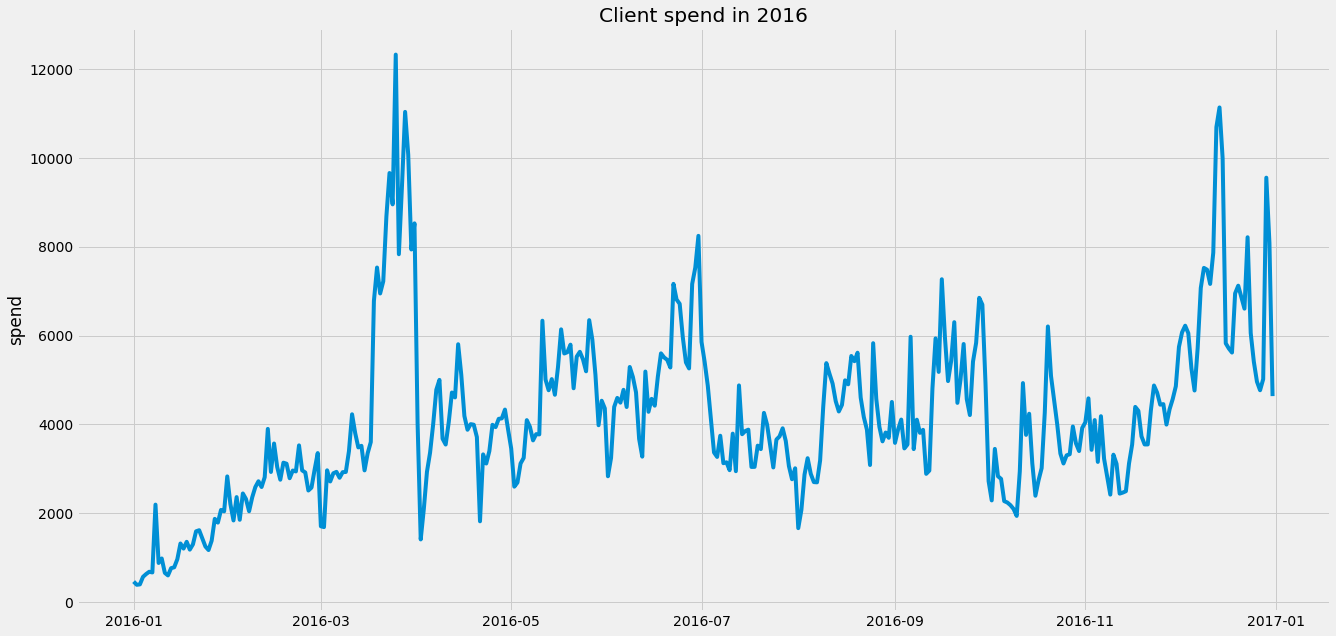

In [757]:
plt.figure(figsize=(20,10))
plt.title('Client spend in 2016');
plt.ylabel('spend')
plt.plot(df.ds, df.y);

We can see some spikes in spend on late March and mid December. The forecast model should pick up on these seasonal times,  as it might indicate some increased impressions during that time for this particular client's business. There is also a slight upward trend in the data. 

In [319]:
df.y.mean()

4158.31010389071

In [96]:
df.sort_values(by='y',ascending=False).head(10)

,ds,y
84,2016-03-25,12326.860930
348,2016-12-14,11136.989690
87,2016-03-28,11037.010310
347,2016-12-13,10694.203330
88,2016-03-29,10071.597690
349,2016-12-15,9991.911768
82,2016-03-23,9660.318094
363,2016-12-29,9555.333782
86,2016-03-27,9375.856700
83,2016-03-24,8954.589996


Let's also quickly aggregate the total spend in 2016. This will be a good naive benchmark for how much they will spend with us in 2017. In 2016, this client spent $1.5M with StackAdapt. 

In [137]:
round(df.y.sum(),2)

1521941.5

## Method 1: Time Series on 2016

In [430]:
# instantiate the Prophet model
# Daily data with weekly trends
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
# Add monthly trend
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# US Holidays
m.add_country_holidays(country_name='US')
m.fit(df)

/Users/gc/anaconda3/lib/python3.6/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [431]:
# forecast 365 days into the future
future = m.make_future_dataframe(periods=365)

# cap is the carrying capacity, estimate max for 2017; forecast should saturate at this point
# take mean in 2016 * (1+40%) ~ 6000
future['cap'] = 6000
forecast = m.predict(future)

In [432]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
726,2017-12-27,9689.58,8424.25,10859.47
727,2017-12-28,9803.20,8583.62,11025.09
728,2017-12-29,9740.03,8557.24,10981.71
729,2017-12-30,8974.11,7772.29,10103.20
730,2017-12-31,8335.27,7141.60,9503.89


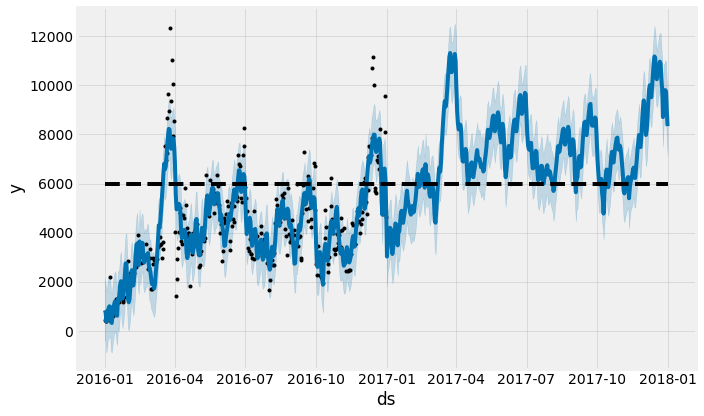

In [433]:
m.plot(forecast);

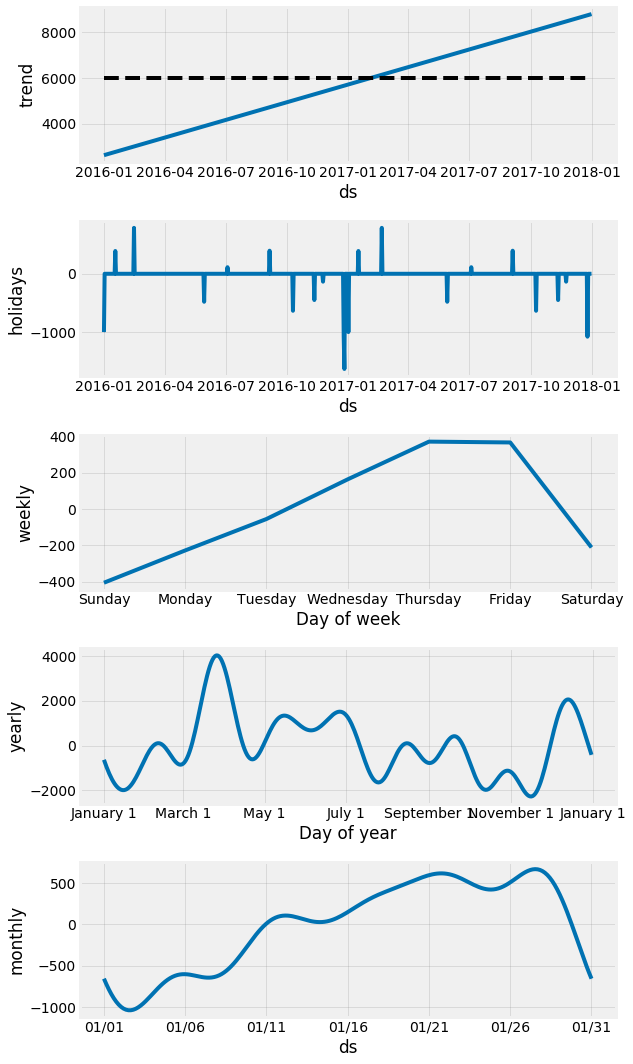

In [434]:
m.plot_components(forecast);

From this decomposition by seasonality, we can see that there is a general trend upwards as time progresses. The model was able to pick up that there is typically more spend right before the weekend (Thursday, Friday). Perhaps, the client is gearing up for weekend sales. It also picked up on the uptick late March and December.

With more data and a better understanding of the client's business, this model can be even more predictive and we can optimize the hyper-parameters even more. 

In [435]:
spend_2017 = forecast[['ds', 'yhat_lower','yhat','yhat_upper']].query('ds>=20170101')

In [436]:
spend_2017.sum()

yhat_lower   2207698.16
yhat         2645162.33
yhat_upper   3081578.36
dtype: float64

In 2017, we're forecasting that this client will be between \\$2.2M and \\$3.1M with StackAdapt, with a mean of $2.6M.

This within the ball park range of 25-40% that the industry has experienced over the last two years. As StackAdapt is a leader in this area, they will lean closer 40% growth rate. 

## Method 2: Extrapolation from 2017
Let's create a new column for spend, using ecpm * impressions = spend

In [456]:
df2 = raw2

In [472]:
# change impressions to float
# remove commas, change to float
df2.impressions = df2.impressions.apply(lambda x: int(x.replace(',','')))
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 7 columns):
country                551 non-null object
device                 551 non-null object
ad_type                551 non-null object
advertiser_category    551 non-null object
bid_type               475 non-null object
impressions            551 non-null int64
ecpm                   551 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 30.2+ KB


In [477]:
df2['spend'] = df2.impressions/1000*df2.ecpm

In [478]:
df2.head()

,country,device,ad_type,advertiser_category,bid_type,impressions,ecpm,spend
0,us,desktop,Native,Travel,cpc,300759,1.97,591.89
1,us,desktop,Native,Health & Fitness,cpc,10866,2.41,26.21
2,us,desktop,Native,Consume Products,cpc,1363194,2.46,3356.18
3,us,desktop,Native,B2B,cpc,1794972,1.31,2347.82
4,us,desktop,Native,Home & Garden,cpc,9,2.38,0.02


In [512]:
jan_total = df2.spend.sum()
jan_total

334047.339732

Actual January spend is \\$334,047. Method 1\'s forecast was \\$133,543.

Considering that Dec 2016's spend was \\$210K, this was a huge lift. Perhaps, driven by beginning of the year marketing spend, or momentum from year end.

In [490]:
spend_2017.query('20170101<=ds<20170201').sum()

yhat_lower    96183.12
yhat         133543.19
yhat_upper   170756.08
dtype: float64

In [493]:
df.query('20161201<=ds<20170101').sum()

y   210175.61
dtype: float64

Let's simply extrapolate January's great month into an annual figure.

In [758]:
jan_total*12

4008568.0767840003

Through method 2, we get a more ambitious mean spend projection of $4M.

# Market insights

In [500]:
df2.describe()

,impressions,ecpm,spend
count,551.00,551.00,551.00
mean,217736.59,3.35,606.26
std,631038.87,3.51,1868.82
min,3.00,0.00,0.00
25%,895.50,1.40,2.51
50%,21672.00,2.46,63.81
75%,126954.00,3.57,374.58
max,6934512.00,21.98,21098.88


In January, the client had 551 ad units. 
* The mean impression is 217,736/ad , with mean ecpm of \\$3.35/ad and spend of \\$606/ad.

In [509]:
# relationship between spend and impressions
df2[['impressions','ecpm','spend']].corr()

,impressions,ecpm,spend
impressions,1.00,-0.06,0.85
ecpm,-0.06,1.00,0.10
spend,0.85,0.10,1.00


There's a very strong correlation between spend and impressions, which is expected as that's inherent in the formula. If StackAdapt can increase impressions or ecpm then spend will increase.

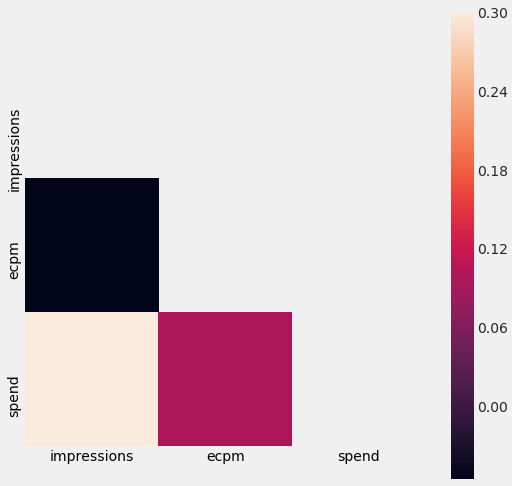

In [508]:
fig, ax = plt.subplots(figsize=(8, 8))
corr = df2[['impressions','ecpm','spend']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, xticklabels = True, yticklabels = True)

In [ ]:
# spend, ecpm and impressions by device

In [528]:
df2.groupby('device').sum()

,impressions,ecpm,spend
device,,,
desktop,54323481,465.39,165156.41
mobile-app,23866770,219.88,71578.58
mobile-web,33393108,429.50,79219.05
tablet-app,1337640,207.16,3560.51
tablet-web,7048077,429.18,14513.63
unknown,3783,92.92,19.15


In [760]:
by_device = df2.groupby('device').sum()
by_device['pct']=by_device.spend/jan_total
by_device.sort_values(by='pct',ascending=False)[['spend','pct']]

,spend,pct
device,,
desktop,165156.41,0.49
mobile-web,79219.05,0.24
mobile-app,71578.58,0.21
tablet-web,14513.63,0.04
tablet-app,3560.51,0.01
unknown,19.15,0.00


49% of the spend is coming from Desktop, followed by mobile-web and mobile-app, then tablet. This is consistent with market trends, with a shift to native mobile advertising.

In [761]:
# spend by ad type
by_ad = df2.groupby('ad_type').sum()
by_ad['pct']=by_ad.spend/jan_total
by_ad.sort_values(by='pct',ascending=False)[['spend','pct']]

,spend,pct
ad_type,,
Native,283504.50,0.85
Video,46024.52,0.14
Display,4518.31,0.01


85% of the spend is coming from Native, followed by Video. This client does not spend much on Display, and is focusing on Native advertisements. We should investigate to see if eCPM is higher for Native ads. In fact, eCPM is actually highest with Video, so the client should consider shifting some spend into that category.

In [531]:
df2.groupby('ad_type').mean()

,impressions,ecpm,spend
ad_type,,,
Display,66119.48,2.62,155.80
Native,257179.02,2.10,644.33
Video,59714.96,10.28,561.27


In [762]:
# spend by advertiser category
df2.groupby('advertiser_category').sum().sort_values(by='spend',ascending=False)['spend']

advertiser_category
Travel                           74030.83
Consume Products                 45809.06
Health & Fitness                 41362.33
News & Society                   30370.09
Home & Garden                    23943.30
Automotive                       21768.78
Personal Finance                 21217.37
B2B                              18072.65
Consumer Services                15889.05
Career & Education               11306.65
Consumer Services, Real Estate    9706.90
Government & Politics             8385.07
Style & Fashion                   2625.40
Family & Parenting                2099.76
Telecom                           1887.12
Food & Drink                      1843.68
CPG                               1697.82
Games                             1306.31
Movies & TV                        725.18
Name: spend, dtype: float64

The client's highest performing category is Travel @ \\$75K, followed by Consumer Products and Health&Fitness. The worst performing category is Movies&TV and Games. More investigation is needed to see if it's because those industries are very competitive for ads.

In [537]:
df2.groupby('advertiser_category').mean().sort_values(by='ecpm',ascending=False)

,impressions,ecpm,spend
advertiser_category,,,
Movies & TV,22375.00,7.06,120.86
Health & Fitness,390139.77,5.34,1060.57
Consumer Services,87357.06,4.90,324.27
Family & Parenting,53047.67,4.38,116.65
Consume Products,331004.80,4.14,1526.97
Travel,422471.62,3.54,1175.09
Career & Education,95000.07,3.50,251.26
Automotive,268927.00,3.41,659.66
Personal Finance,137582.64,3.07,365.82


In [538]:
df2.groupby('advertiser_category').mean().sort_values(by='impressions',ascending=False)

,impressions,ecpm,spend
advertiser_category,,,
News & Society,516365.71,2.01,979.68
Travel,422471.62,3.54,1175.09
Health & Fitness,390139.77,5.34,1060.57
Consume Products,331004.80,4.14,1526.97
Automotive,268927.00,3.41,659.66
"Consumer Services, Real Estate",260430.80,2.51,647.13
Home & Garden,238213.50,2.67,1197.16
B2B,190369.21,2.50,384.52
Personal Finance,137582.64,3.07,365.82


Health&Fitness, Consumer Products have a lot of impressions and high eCPM. Client should spend more money in future months in these two advertiser_category.

In [764]:
# spend by bid type
by_bid_type = df2.groupby('bid_type').sum()
by_bid_type['pct']=by_bid_type.spend/jan_total
by_bid_type.sort_values(by='pct',ascending=False)[['spend','pct']]

,spend,pct
bid_type,,
cpm,250190.03,0.75
cpe,43092.01,0.13
cpc,30208.77,0.09
cpcv,10556.54,0.03


Over 75% of spend is by 'cpm' bid_type. That is the bid_type that wins the most bids. Earnings is consistently highest with video views, followed by impressions, then clicks.

In [543]:
df2.groupby('bid_type').mean().sort_values(by='ecpm',ascending=False)

,impressions,ecpm,spend
bid_type,,,
cpcv,70195.20,10.12,527.83
cpm,318735.74,4.67,965.98
cpc,151308.75,2.44,343.28
cpe,210158.39,2.02,399.00


In [546]:
# ad unit with greatest eCPM
df2.ecpm.max()

21.982

In [553]:
df2.sort_values(by='ecpm',ascending=False).head(10)

,country,device,ad_type,advertiser_category,bid_type,impressions,ecpm,spend
238,us,desktop,Video,Health & Fitness,cpm,72915,21.98,1602.82
323,us,tablet-web,Video,Health & Fitness,cpm,14334,19.12,274.04
269,us,mobile-web,Video,Health & Fitness,cpm,153675,18.75,2881.41
271,us,mobile-web,Video,Career & Education,cpm,131097,17.89,2345.85
321,us,tablet-web,Video,Career & Education,cpm,18081,17.68,319.71
446,gb,desktop,Video,Consumer Services,cpm,17820,17.56,312.95
240,us,desktop,Video,Career & Education,cpm,51132,16.17,826.70
453,gb,mobile-web,Video,Consumer Services,cpm,4410,15.52,68.43
460,gb,tablet-web,Video,Consumer Services,cpm,408,15.02,6.13
107,gb,tablet-web,Video,Family & Parenting,cpcv,270,13.75,3.71


Top 10 units were cpm bid_type and in the Health&Fitness/Career&Education/Consumer Services, video ad_type.

In [560]:
# ad unit with greatest spend
df2.spend.max()

21098.876652

In [561]:
df2.sort_values(by='spend',ascending=False).head(10)

,country,device,ad_type,advertiser_category,bid_type,impressions,ecpm,spend
219,us,desktop,Native,Consume Products,cpm,2785698,7.57,21098.88
221,us,desktop,Native,Home & Garden,cpm,2082570,8.79,18297.46
216,us,desktop,Native,News & Society,cpm,6934512,1.84,12773.37
217,us,desktop,Native,Travel,cpm,3641133,3.21,11680.75
218,us,desktop,Native,Health & Fitness,cpm,4929189,2.20,10834.36
251,us,mobile-web,Native,Health & Fitness,cpm,4937439,2.01,9914.38
250,us,mobile-web,Native,Travel,cpm,4166895,2.32,9650.53
361,ca,desktop,Native,Travel,cpm,4096089,2.23,9134.28
286,us,mobile-app,Native,Health & Fitness,cpm,2658339,3.09,8203.63
284,us,mobile-app,Native,Travel,cpm,2609247,2.84,7415.48


Top 10 units spent were also cpm bid_type and in the Travel & Health & Fitness categories, Native ad_type space. 

In [547]:
# ad unit with lowest eCPM
df2.ecpm.min()

0.0

In [554]:
df2.sort_values(by='ecpm',ascending=False).tail(10)

,country,device,ad_type,advertiser_category,bid_type,impressions,ecpm,spend
503,us,tablet-web,Native,Health & Fitness,NaN,3,0.00,0.00
502,us,tablet-web,Native,Personal Finance,NaN,6,0.00,0.00
501,us,tablet-web,Native,Consumer Services,NaN,12,0.00,0.00
500,us,tablet-web,Native,Style & Fashion,NaN,12,0.00,0.00
499,us,tablet-web,Native,Travel,NaN,24,0.00,0.00
498,us,mobile-app,Native,B2B,NaN,3,0.00,0.00
497,us,mobile-app,Native,News & Society,NaN,3,0.00,0.00
496,us,mobile-app,Native,Career & Education,NaN,6,0.00,0.00
495,us,mobile-app,Native,Personal Finance,NaN,6,0.00,0.00
550,gb,mobile-web,Native,Consumer Services,NaN,3,0.00,0.00


Worst 10 units were units where it generated no earnings and did not win any bids in the auction. No specific ad category, but it tended to be a native ad_type. There were 76 ad units that did not generate any spend.

In [559]:
# ad unit with lowest spend
df2.spend.min()

0.0

In [557]:
df2[df2['spend']==0].count()

country                76
device                 76
ad_type                76
advertiser_category    76
bid_type                0
impressions            76
ecpm                   76
spend                  76
dtype: int64

Text(0, 0.5, 'count')

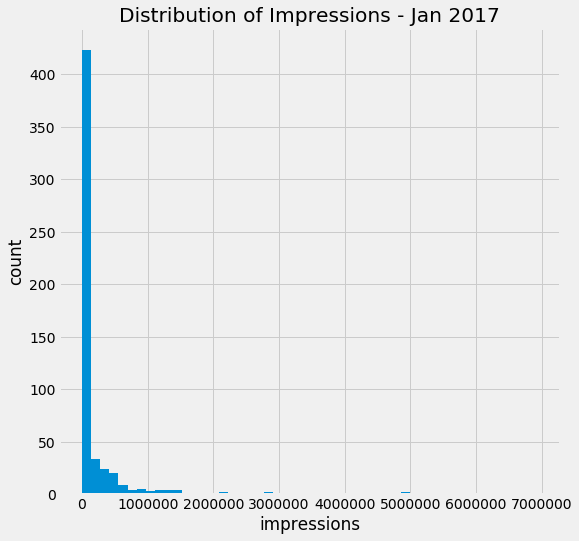

In [595]:
# Distribution of impressions
# Very large range, left skewed, many ad units with very little impressions
# 25% have less than 1000
plt.figure(figsize=(8,8))
plt.title('Distribution of Impressions - Jan 2017')
plt.hist(df2.impressions, bins=50)
plt.xlabel('impressions')
plt.ylabel('count')

Text(0, 0.5, 'count')

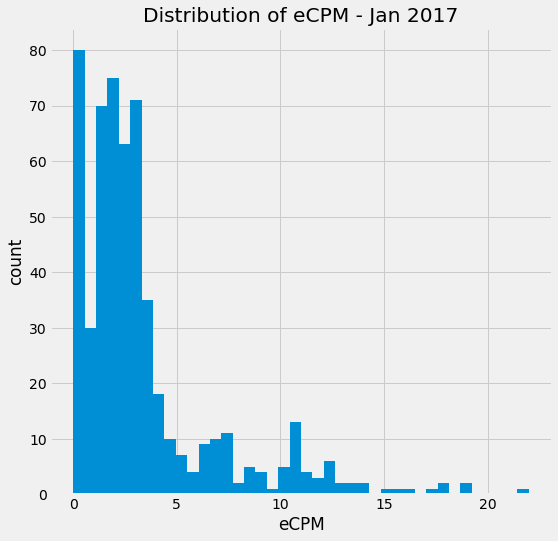

In [600]:
# Distribution of eCPM
# Also left skewed, mostly around 0-4 eCPM
plt.figure(figsize=(8,8))
plt.title('Distribution of eCPM - Jan 2017')
plt.hist(df2.ecpm, bins=40)
plt.xlabel('eCPM')
plt.ylabel('count')

Text(0, 0.5, 'count')

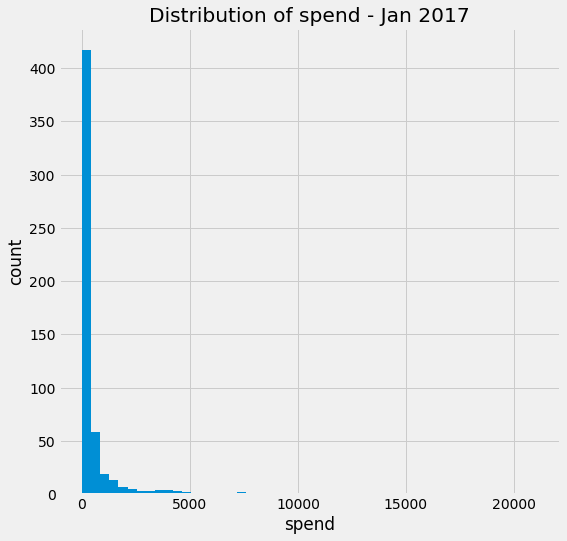

In [603]:
# Distribution of spend
# Also left skewed, follows distribution of impressions
plt.figure(figsize=(8,8))
plt.title('Distribution of spend - Jan 2017')
plt.hist(df2.spend, bins=50)
plt.xlabel('spend')
plt.ylabel('count')

# 3 Analysis
a) Which key descriptive stats from the data set would you use to summarize our media buying?

In [612]:
bid_df = pd.read_csv("bid_factoring.csv")

In [613]:
bid_df.shape

(306, 12)

In [614]:
bid_df.head()

,bid_type,exchange,environment,device,size/format,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability
0,cpc,1,web,desktop,in-image,170741.86,41412750,387855,24360,3153180,1449270,0.46
1,cpc,1,web,mobile-web,in-image,778938.21,105943050,2051700,65055,3386115,2313675,0.68
2,cpc,4,app,mobile-app,in-feed,1532084.88,272060205,3743550,431130,0,0,0.00
3,cpc,9,app,mobile-app,in-feed,459083.72,89530095,1069155,210885,0,0,0.00
4,cpc,13,app,mobile-app,in-feed,97524.84,40317180,187830,20250,0,0,0.00


In [618]:
bid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 12 columns):
bid_type       306 non-null object
exchange       306 non-null int64
environment    306 non-null object
device         306 non-null object
size/format    306 non-null object
media_cost     306 non-null float64
impressions    306 non-null int64
clicks         306 non-null int64
engagements    306 non-null int64
view_m         306 non-null int64
view_50v_2s    306 non-null int64
viewability    306 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 28.8+ KB


In [616]:
bid_df.isnull().sum()

bid_type       0
exchange       0
environment    0
device         0
size/format    0
media_cost     0
impressions    0
clicks         0
engagements    0
view_m         0
view_50v_2s    0
viewability    0
dtype: int64

To inspect this media buy, let's add columns to calculate CPM, CPC, CPE as our client may consider all of these KPIs. We will back these out so it meets the client's goals.

In [645]:
# cpm = media_cost / impressions * 1000
bid_df['cpm'] = bid_df.media_cost / bid_df.impressions * 1000

In [644]:
# cpc = media_cost / cpc
bid_df['cpc'] = bid_df.media_cost / bid_df.clicks

In [643]:
# cpe = media_cost / cpe
bid_df['cpe'] = bid_df.media_cost / bid_df.engagements

In [646]:
# 306 rows, # replace inf with nan, so I can capture summary statistics
bid_df = bid_df.replace([np.inf,-np.inf],np.nan)

In [647]:
bid_df.describe()

,exchange,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
count,306.00,306.00,306.00,306.00,306.00,306.00,306.00,306.00,305.00,288.00,267.00
mean,75.57,123726.35,69294646.37,205594.07,37059.46,16242229.85,8831116.13,0.32,3.61,0.92,15.07
std,31.70,356048.62,152915425.26,918103.80,183419.91,52582451.89,31427257.27,0.31,31.66,1.10,46.77
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
25%,54.00,1050.05,1040962.50,1736.25,93.75,0.00,0.00,0.00,0.57,0.40,1.40
50%,87.00,8143.79,10009485.00,13680.00,1867.50,22717.50,10147.50,0.34,1.09,0.61,4.66
75%,95.00,63236.05,56051055.00,78345.00,11865.00,4125480.00,2481941.25,0.59,2.36,0.96,11.73
max,116.00,4087466.54,1217837475.00,13698000.00,2512725.00,459642795.00,377280240.00,1.00,552.79,10.63,472.00


In [655]:
The most expensive ad units on average are those of bid_type cpe (15.07), then cpm (3.61) then by clicks (0.92).
The variance of cpm and cpe ad types are greater than the variance of cpc.

(306, 15)

b) Please create a table with KPIs by ad placement. Feel free to aggregate certain fields in the original data table to consolidate some rows.

We are buying media for our advertising clients, and generally they want to lower their costs.

* low CPM
* low CPC
* low eCPM

Let's group by size/format, device and environment

In [658]:
bid_df.groupby('size/format').mean()

,exchange,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
size/format,,,,,,,,,,,
1024x768,90.00,506.59,223651.67,14958.33,25.00,2086.67,1651.67,0.53,1.60,0.15,14.29
160x600,90.24,4198.26,3326764.41,2159.12,150.00,1414574.12,867506.47,0.51,1.00,1.21,27.05
300x250,95.92,141148.12,154690665.61,104688.98,12956.33,55067263.16,28745092.35,0.42,0.91,1.34,9.80
300x600,93.18,16213.09,14067558.46,16149.62,2852.69,5142079.62,2775708.85,0.43,1.98,1.17,5.38
320x480,89.33,48.46,19505.00,1055.00,165.00,4448.00,3487.00,0.33,4.56,0.24,1.60
320x50,88.38,55984.76,44360330.62,44844.38,4039.69,8568148.12,6245816.25,0.47,1.08,1.03,77.06
480x320,86.00,0.06,15.00,0.00,0.00,15.00,15.00,1.00,4.26,nan,nan
728x90,90.18,26722.99,21880696.36,37628.86,4363.64,5043133.64,2490607.50,0.40,1.19,1.22,34.32
970x250,90.00,11630.37,9653665.00,34024.44,3501.67,3264680.00,1253101.67,0.39,21.60,0.46,4.08


In [663]:
bid_df.groupby('size/format').count()

,bid_type,exchange,environment,device,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
size/format,,,,,,,,,,,,,,
1024x768,9,9,9,9,9,9,9,9,9,9,9,9,6,2
160x600,17,17,17,17,17,17,17,17,17,17,17,16,17,13
300x250,49,49,49,49,49,49,49,49,49,49,49,49,44,43
300x600,39,39,39,39,39,39,39,39,39,39,39,39,36,33
320x480,15,15,15,15,15,15,15,15,15,15,15,15,12,8
320x50,16,16,16,16,16,16,16,16,16,16,16,16,16,14
480x320,1,1,1,1,1,1,1,1,1,1,1,1,0,0
728x90,22,22,22,22,22,22,22,22,22,22,22,22,22,22
970x250,27,27,27,27,27,27,27,27,27,27,27,27,26,26


In [659]:
bid_df.groupby('device').mean()

,exchange,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
device,,,,,,,,,,,
desktop,79.42,102822.32,68719807.83,96458.36,20343.45,23376992.65,12085142.65,0.38,1.41,1.30,17.68
mobile-app,65.00,162709.18,52802830.89,443050.48,93645.41,0.00,0.00,0.00,10.65,0.55,10.73
mobile-web,78.38,119696.43,79868473.75,163910.88,18377.25,19404351.38,11139170.12,0.46,1.47,0.78,14.96


In [664]:
bid_df.groupby('device').count()

,bid_type,exchange,environment,size/format,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
device,,,,,,,,,,,,,,
desktop,113,113,113,113,113,113,113,113,113,113,113,113,107,104
mobile-app,73,73,73,73,73,73,73,73,73,73,73,72,65,60
mobile-web,120,120,120,120,120,120,120,120,120,120,120,120,116,103


In [766]:
bid_df.groupby(['size/format','device']).mean()

exchange  media_cost  impressions     clicks  \
size/format device                                                     
1024x768    desktop        91.67       15.11     13180.00      60.00   
            mobile-app     89.33     1500.01    655750.00   44770.00   
            mobile-web     89.00        4.66      2025.00      45.00   
160x600     desktop        90.50     7720.99   6021196.88    3461.25   
            mobile-app     86.00       10.78         0.00      15.00   
            mobile-web     90.50     1198.97   1048177.50    1125.00   
300x250     desktop        96.17   178034.08 191117865.83   73079.17   
            mobile-app     93.50    45961.13  27703113.75   59371.25   
            mobile-web     97.21   166321.62 200383350.79  163256.84   
300x600     desktop        94.56    27477.02  25532022.19   17009.06   
            mobile-app     89.62     4636.81    840221.25   16470.00   
            mobile-web     93.60    10372.25   8893377.00   15062.00   
320x480     desktop        87.00        0.50       442.50       0.00   
            mobile-app     89.33       92.45     33452.50     767.50   
            mobile-web     90.00       24.46     12996.43    1602.86   
320x50      desktop        89.00      811.12    744635.00    1277.50   
            mobile-app     86.50   126778.53  78265162.50  108907.50   
            mobile-web     89.00    63962.56  65372805.00   45702.50   
480x320     desktop        86.00        0.06        15.00       0.00   
728x90      desktop        90.50    31325.67  28591451.25   18720.00   
            mobile-app     89.33    39593.35  26482645.00  100040.00   
            mobile-web     90.50    12467.53  11718480.00    9729.38   
970x250     desktop        90.50    22396.53  18242720.00   68001.25   
            mobile-app     86.00       11.26       110.00      25.00   
            mobile-web     90.50     3768.99   3477998.75    8547.50   
in-feed     desktop        47.12   255557.25 106219163.12  291403.75   
            mobile-app     23.75   438973.97 126578092.50 1263215.00   
            mobile-web     47.12   318958.64 156712254.38  421744.38   
in-image    desktop        58.00   112334.68  39311222.50  183672.50   
            mobile-web     58.00   331823.27 100845505.00  810180.00   
widgets     desktop        72.00    64583.31  70139446.67   23910.00   
            mobile-app     51.00      665.60    574747.50    1072.50   
            mobile-web     59.25    71950.77  61763522.50   73631.25   

                        engagements      view_m  view_50v_2s  viewability  \
size/format device                                                          
1024x768    desktop            0.00     5650.00      4460.00         0.88   
            mobile-app        75.00        0.00         0.00         0.00   
            mobile-web         0.00      610.00       495.00         0.71   
160x600     desktop          238.12  2601631.88   1627854.38         0.58   
            mobile-app         0.00        0.00         0.00         0.00   
            mobile-web        80.62   404338.12    215596.88         0.50   
300x250     desktop        11814.17 92620390.83  45185400.00         0.44   
            mobile-app     11438.75        0.00         0.00         0.00   
            mobile-web     14996.84 54269940.00  31324859.21         0.67   
300x600     desktop         3689.06 10082830.31   5383814.06         0.50   
            mobile-app      2077.50        0.00         0.00         0.00   
            mobile-web      2374.00  2614388.00   1474108.00         0.59   
320x480     desktop            0.00      427.50       285.00         0.83   
            mobile-app       160.00        0.00         0.00         0.00   
            mobile-web       216.43     9409.29      7390.71         0.48   
320x50      desktop           62.50   232055.00    129187.50         0.49   
            mobile-app     11520.00        0.00         0.00         0.00   
            mobile-web      3030.00 2261

c) Which ad units perform the best? On which exchanges? (please also include the model in your work)

Now that we have the KPIs of cpc, cpm and cpe, we can answer questions such as:
- which ad units performed best
- on which exchange?

Ad units perform well when the cpc, cpm and cpe are low. We are bidding the lowest to get clicks, impressions and engagements and high viewability.

In [768]:
# make sure we actually get impressions
# top 10 ad units by cpm
bid_df.query('bid_type=="cpm"&impressions>0').sort_values(by='cpm').head(10)

,bid_type,exchange,environment,device,size/format,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
248,cpm,87,web,desktop,970x250,22821.84,53081460,109035,25260,15690180,6357825,0.41,0.43,0.21,0.90
288,cpm,95,web,mobile-web,320x480,1.49,3105,30,0,150,0,0.00,0.48,0.05,nan
266,cpm,94,web,mobile-web,1024x768,0.53,900,105,0,870,765,0.88,0.59,0.01,nan
205,cpm,46,web,mobile-web,in-feed,83909.86,132668625,101925,20220,0,0,0.00,0.63,0.82,4.15
204,cpm,46,web,desktop,in-feed,81997.68,114667440,33300,5910,0,0,0.00,0.72,2.46,13.87
243,cpm,87,web,desktop,300x250,357478.50,482401035,106035,26655,310059300,100485465,0.32,0.74,3.37,13.41
254,cpm,87,web,mobile-web,320x50,72549.80,94507470,51870,3765,36215130,25109715,0.69,0.77,1.40,19.27
256,cpm,87,web,mobile-web,970x250,2374.04,3071130,11370,3105,929925,601290,0.65,0.77,0.21,0.76
281,cpm,95,web,desktop,300x250,458729.95,587186250,154515,18315,260859480,70971285,0.27,0.78,2.97,25.05
284,cpm,95,web,desktop,970x250,26640.69,33961065,93570,4140,8807610,2705910,0.31,0.78,0.28,6.43


In [740]:
bid_df.query('bid_type=="cpm"&impressions>0').sort_values(by='cpm').head(10).groupby('exchange').mean().sort_values(by='cpm')

,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
exchange,,,,,,,,,,
94,0.53,900.00,105.00,0.00,870.00,765.00,0.88,0.59,0.01,nan
46,82953.77,123668032.50,67612.50,13065.00,0.00,0.00,0.00,0.67,1.64,9.01
87,113806.04,158265273.75,69577.50,14696.25,90723633.75,33138573.75,0.52,0.68,1.30,8.59
95,161790.71,207050140.00,82705.00,7485.00,89889080.00,24559065.00,0.19,0.68,1.10,15.74


In [ ]:
# e.g. cpc is low on this device and this format so we should buy more of this; 
# cpc is high on this device and this format so we should stop buying this;
# optimize for these exchanges (46, 95, 87) for cpm

In [727]:
# top 10 ad units by cpc
# xchange 95 and 87
bid_df.query('bid_type=="cpc"&clicks>0').sort_values(by='cpc').head(10)

,bid_type,exchange,environment,device,size/format,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
93,cpc,95,web,mobile-web,320x480,6.95,5250,30,0,660,150,0.23,1.32,0.23,nan
83,cpc,95,app,mobile-app,320x480,19.88,645,75,0,0,0,0.00,30.82,0.27,nan
82,cpc,95,app,mobile-app,300x600,21.04,63570,75,0,0,0,0.00,0.33,0.28,nan
60,cpc,87,web,mobile-web,160x600,9.76,11955,30,0,5550,2085,0.38,0.82,0.33,nan
17,cpc,32,app,mobile-app,in-feed,101241.19,19427970,271635,18555,0,0,0.00,5.21,0.37,5.46
63,cpc,87,web,mobile-web,320x480,55.98,3555,150,15,2385,1500,0.63,15.75,0.37,3.73
1,cpc,1,web,mobile-web,in-image,778938.21,105943050,2051700,65055,3386115,2313675,0.68,7.35,0.38,11.97
50,cpc,87,app,mobile-app,320x480,30.13,9435,75,15,0,0,0.00,3.19,0.40,2.01
105,cpc,109,web,desktop,300x250,20319.79,58565100,50400,12930,34048050,30157575,0.89,0.35,0.40,1.57
7,cpc,14,app,mobile-app,in-feed,22882.05,5117985,56535,3450,0,0,0.00,4.47,0.40,6.63


In [736]:
bid_df.query('bid_type=="cpc"&clicks>0').sort_values(by='cpc').head(10).groupby('exchange').mean().sort_values(by='cpc')

,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
exchange,,,,,,,,,,
95,15.96,23155,60,0,220,50,0.08,10.82,0.26,nan
87,31.96,8315,85,10,2645,1195,0.33,6.59,0.37,2.87
32,101241.19,19427970,271635,18555,0,0,0.00,5.21,0.37,5.46
1,778938.21,105943050,2051700,65055,3386115,2313675,0.68,7.35,0.38,11.97
109,20319.79,58565100,50400,12930,34048050,30157575,0.89,0.35,0.40,1.57
14,22882.05,5117985,56535,3450,0,0,0.00,4.47,0.40,6.63


In [729]:
bid_df.query('bid_type=="cpe"&engagements>0').sort_values(by='cpe').head(10)

,bid_type,exchange,environment,device,size/format,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
131,cpe,49,app,mobile-app,in-feed,16849.16,6204750,106920,26880,0,0,0.00,2.72,0.16,0.63
126,cpe,32,app,mobile-app,in-feed,30066.52,9624360,133365,43770,0,0,0.00,3.12,0.23,0.69
147,cpe,87,app,mobile-app,300x250,14353.93,18082785,59985,20235,0,0,0.00,0.79,0.24,0.71
111,cpe,4,app,mobile-app,in-feed,1053202.80,264644055,4012860,1357095,0,0,0.00,3.98,0.26,0.78
113,cpe,13,app,mobile-app,in-feed,56620.73,29506410,138165,64935,0,0,0.00,1.92,0.41,0.87
122,cpe,21,app,mobile-app,widgets,123.15,535650,930,135,0,0,0.00,0.23,0.13,0.91
124,cpe,28,web,desktop,widgets,8505.29,36029340,12135,9060,0,0,0.00,0.24,0.70,0.94
112,cpe,9,app,mobile-app,in-feed,467218.29,99965955,1106760,492705,0,0,0.00,4.67,0.42,0.95
163,cpe,95,app,mobile-app,300x250,4682.78,6227820,11145,4770,0,0,0.00,0.75,0.42,0.98
139,cpe,86,app,mobile-app,300x600,3972.71,349455,9945,4035,0,0,0.00,11.37,0.40,0.98


In [738]:
bid_df.query('bid_type=="cpe"&engagements>0').sort_values(by='cpe').head(10).groupby('exchange').mean().sort_values(by='cpe')

,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
exchange,,,,,,,,,,
49,16849.16,6204750,106920,26880,0,0,0.00,2.72,0.16,0.63
32,30066.52,9624360,133365,43770,0,0,0.00,3.12,0.23,0.69
87,14353.93,18082785,59985,20235,0,0,0.00,0.79,0.24,0.71
4,1053202.80,264644055,4012860,1357095,0,0,0.00,3.98,0.26,0.78
13,56620.73,29506410,138165,64935,0,0,0.00,1.92,0.41,0.87
21,123.15,535650,930,135,0,0,0.00,0.23,0.13,0.91
28,8505.29,36029340,12135,9060,0,0,0.00,0.24,0.70,0.94
9,467218.29,99965955,1106760,492705,0,0,0.00,4.67,0.42,0.95
95,4682.78,6227820,11145,4770,0,0,0.00,0.75,0.42,0.98


In [ ]:
# Distribution of exchanges are less top heavy

In [744]:
# ads with the highest viewability
bid_df.sort_values(by='viewability', ascending=False)

,bid_type,exchange,environment,device,size/format,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
45,cpc,86,web,mobile-web,320x480,24.00,7050,30,0,345,345,1.00,3.40,0.80,nan
56,cpc,87,web,desktop,320x480,0.00,30,0,0,30,30,1.00,0.00,nan,nan
225,cpm,86,web,desktop,480x320,0.06,15,0,0,15,15,1.00,4.26,nan,nan
259,cpm,94,web,desktop,1024x768,0.05,45,0,0,45,45,1.00,1.13,nan,nan
181,cpe,109,web,mobile-web,300x250,0.00,2040,0,0,675,630,0.93,0.00,nan,nan
46,cpc,86,web,mobile-web,320x50,7079.94,12201495,7380,15,2868225,2643210,0.92,0.58,0.96,472.00
105,cpc,109,web,desktop,300x250,20319.79,58565100,50400,12930,34048050,30157575,0.89,0.35,0.40,1.57
106,cpc,109,web,mobile-web,300x250,0.00,18210,0,0,6465,5685,0.88,0.00,nan,nan
266,cpm,94,web,mobile-web,1024x768,0.53,900,105,0,870,765,0.88,0.59,0.01,nan
180,cpe,109,web,desktop,300x250,6607.31,12279405,10815,5715,6577095,5717700,0.87,0.54,0.61,1.16


In [752]:
bid_df.sort_values(by='viewability', ascending=False).head(100).groupby('size/format').mean().sort_values(by='viewability', ascending=False)

,exchange,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
size/format,,,,,,,,,,,
480x320,86.00,0.06,15.00,0.00,0.00,15.00,15.00,1.00,4.26,nan,nan
1024x768,91.00,11.85,9117.00,63.00,0.00,3750.00,2970.00,0.85,1.69,0.22,nan
320x480,86.67,26.70,13365.00,1860.00,252.50,10522.50,8677.50,0.79,3.86,0.32,1.38
300x250,101.16,143305.62,158158938.16,109989.47,13211.84,56509501.58,40884930.00,0.73,1.06,1.84,11.72
320x50,88.11,42971.59,43796190.00,30856.67,2033.33,15169640.00,11079235.00,0.72,0.91,1.11,83.75
728x90,90.38,19681.43,14359935.00,13771.88,652.50,4689626.25,3159101.25,0.69,1.08,1.19,43.45
in-image,1.00,339591.19,80626642.50,1287633.75,77253.75,6895297.50,4238647.50,0.65,3.92,0.25,4.72
970x250,90.14,2739.65,2706769.29,7043.57,1232.14,736583.57,455162.14,0.64,1.00,0.42,4.55
300x600,94.71,20715.08,17812470.88,19414.41,3898.24,7026107.65,4048629.71,0.63,1.59,1.31,6.87


In [ ]:
# view-ability is greatest on average for the following size/formats

In [773]:
bid_df.sort_values(by='viewability', ascending=False).groupby('device').mean().sort_values(by='viewability', ascending=False)

,exchange,media_cost,impressions,clicks,engagements,view_m,view_50v_2s,viewability,cpm,cpc,cpe
device,,,,,,,,,,,
mobile-web,78.38,119696.43,79868473.75,163910.88,18377.25,19404351.38,11139170.12,0.46,1.47,0.78,14.96
desktop,79.42,102822.32,68719807.83,96458.36,20343.45,23376992.65,12085142.65,0.38,1.41,1.30,17.68
mobile-app,65.00,162709.18,52802830.89,443050.48,93645.41,0.00,0.00,0.00,10.65,0.55,10.73


In [ ]:
# higher on mobile-web than desktop, it is not captured for mobile-apps since there's no JS tag